In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize

In [62]:
FilePath = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv"
small_df = pd.read_csv(FilePath)

In [63]:
Label = small_df["label"]
Data = small_df.drop(columns=["label"])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(Data, Label, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (8012, 2352)
Testing set shape: (2003, 2352)


In [65]:
# oversample = RandomOverSampler()
# Data,Label  = oversample.fit_resample(Data,Label)
# Data = np.array(Data).reshape(-1,28,28,3)
# print('Shape of Data :',Data.shape)

oversample = RandomOverSampler()
X_train,y_train  = oversample.fit_resample(X_train,y_train)
X_train = np.array(X_train).reshape(-1,28,28,3)
print('Shape of Data :',X_train.shape)

Shape of Data : (37569, 28, 28, 3)


In [66]:
# datagen = ImageDataGenerator(
#     rescale=1./255,           # Normalize pixel values to [0,1]
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.2,
#     fill_mode='nearest'
# )

In [67]:
# datagen.fit(X_train)

In [68]:
y_train.shape

(37569,)

In [69]:
X_test = np.array(X_test).reshape(-1,28,28,3)

In [70]:
X_test.shape

(2003, 28, 28, 3)

In [71]:
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [72]:
y_test.shape

(2003,)

In [73]:
# Define the model
def create_model(input_shape, num_classes):
    # Image input
    img_input = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=img_input)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    
    # Additional layers
    x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
    x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[img_input], outputs=output)
    return model

In [74]:
X_train.shape[1:]

(28, 28, 3)

In [76]:
# Create and compile the model
input_shape = X_train.shape[1:]

model = create_model(input_shape, num_classes=7)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_test, y_test_cat),
    epochs=30,
#     batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
  19/1174 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.1246 - loss: 15.3246 

W0000 00:00:1722534639.713858      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1139/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4658 - loss: 9.3409

W0000 00:00:1722534659.580620      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.4690 - loss: 9.2675 - val_accuracy: 0.5916 - val_loss: 4.3159 - learning_rate: 1.0000e-04
Epoch 2/30
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7264 - loss: 3.6179 - val_accuracy: 0.6061 - val_loss: 2.9260 - learning_rate: 1.0000e-04
Epoch 3/30
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7939 - loss: 2.3671 - val_accuracy: 0.6331 - val_loss: 2.2715 - learning_rate: 1.0000e-04
Epoch 4/30
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8266 - loss: 1.7527 - val_accuracy: 0.5946 - val_loss: 2.0448 - learning_rate: 1.0000e-04
Epoch 5/30
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8563 - loss: 1.3633 - val_accuracy: 0.6176 - val_loss: 1.7580 - learning_rate: 1.0000e-04
Epoch 6/30
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8760 - loss: 1.0994 - val_accuracy: 0.6206 - val_loss: 1.6572 - learning_rate: 1.0000e-04
Epoch 7/30
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step -

In [77]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test], y_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")

21/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7051 - loss: 1.1333

W0000 00:00:1722535025.336698      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7062 - loss: 1.1456
Test accuracy: 0.7094


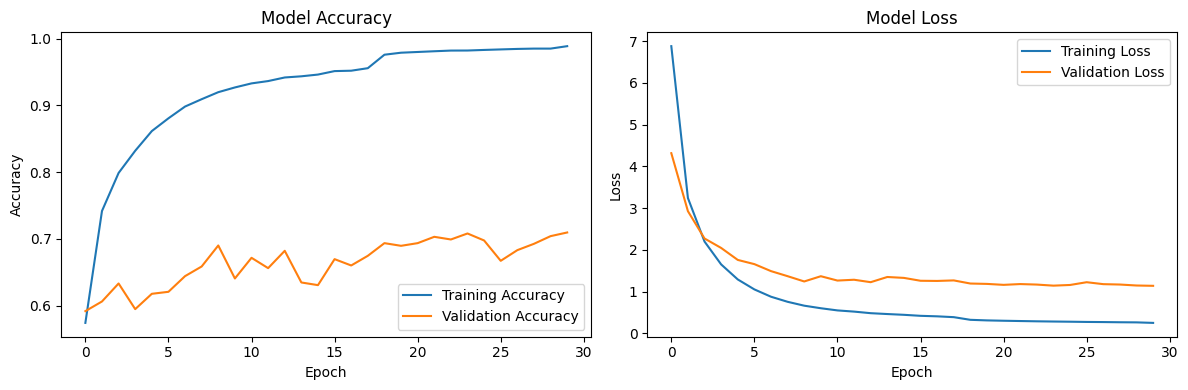

In [78]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
# Get predictions
y_pred = model.predict([X_test])

# Convert true labels to one-hot encoding if not already
y_true = y_test_cat if y_test_cat.ndim == 2 else label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC AUC
roc_auc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')

# Calculate mean Average Precision
map_score = average_precision_score(y_true, y_pred, average='macro')

# Calculate F1 Score
# First, convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Mean Average Precision: {map_score:.4f}")
print(f"F1 Score: {f1:.4f}")

28/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1722535050.599129      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step
ROC AUC: 0.8844
Mean Average Precision: 0.4403
F1 Score: 0.7110


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Normalized Multi-Class Accuracy: 0.4532

Per-class Accuracies:
Class 0: 0.2464
Class 1: 0.5054
Class 2: 0.4474
Class 3: 0.2143
Class 4: 0.8535
Class 5: 0.4762
Class 6: 0.4292


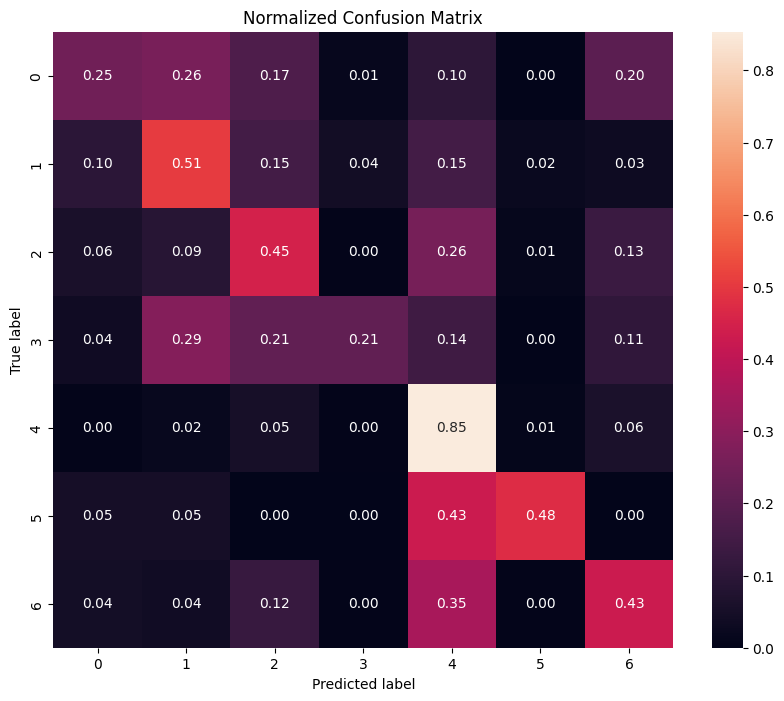

In [80]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions if you haven't already
y_pred = model.predict([X_test])

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Get unique class names
class_names = np.unique(y_true_classes)

def normalized_multi_class_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_accuracies = cm.diagonal()
    return np.mean(class_accuracies)

# Calculate NMCA
nmca = normalized_multi_class_accuracy(y_true_classes, y_pred_classes)

print(f"Normalized Multi-Class Accuracy: {nmca:.4f}")

# Calculate per-class accuracies
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracies = cm_normalized.diagonal()

print("\nPer-class Accuracies:")
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f"Class {class_name}: {accuracy:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()